## Assignment 9, Dataset 10
## Student Name: Paria Ighanian, Student ID: 0200155529


In [1]:
import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
# Load the graph
facebook_G = nx.read_edgelist('Facebook-Ego/3437_3.edges', nodetype=int)

facebook_num_nodes = facebook_G.number_of_nodes()
facebook_num_edges = facebook_G.number_of_edges()
print('Facebook-Ego Netwrok \n----------------------------')
print(f"Number of nodes: {facebook_num_nodes}")
print(f"Number of edges: {facebook_num_edges}")

Facebook-Ego Netwrok 
----------------------------
Number of nodes: 133
Number of edges: 325


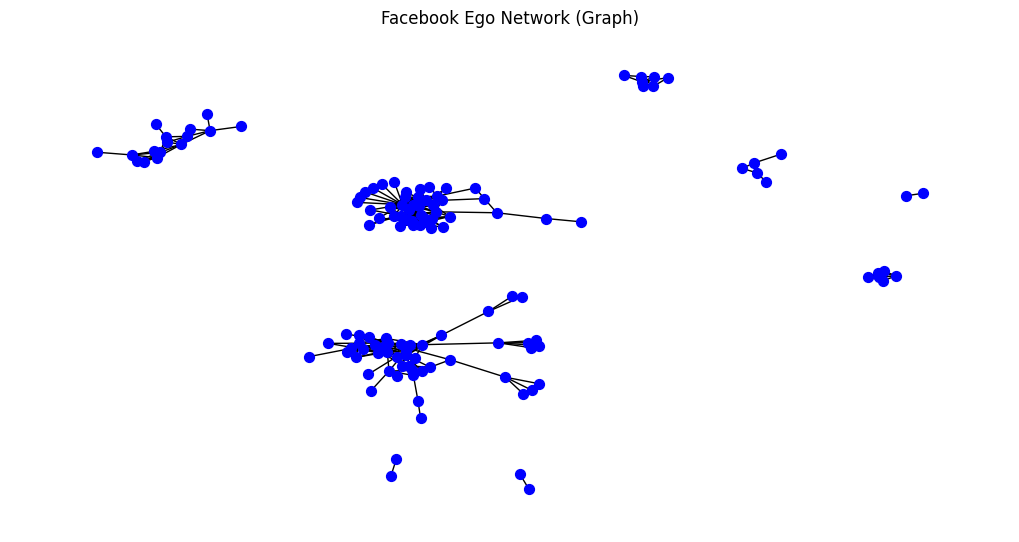

In [3]:
# Plot the graph
plt.figure(figsize=(10, 5))  
nx.draw(facebook_G, with_labels=False, node_size=50, node_color='blue')
plt.title("Facebook Ego Network (Graph)")
plt.show()

### We can predict links based on available features in the graph. Please randomly delete 10% of the edges in the graph, and use any features to train a conventional machine learning algorithm to predict the deleted edges. Please output a report of the prediction accuracy, AUROC, precision and ROC curve.


In [8]:
random.seed(42)

# Randomly delete 10% of edges
all_edges = list(facebook_G.edges)
num_edges_to_remove = int(0.1 * len(all_edges))
removed_edges = random.sample(all_edges, num_edges_to_remove)

# Remove these edges from the graph
facebook_G.remove_edges_from(removed_edges)

# Feature engineering: Define helper functions for features
def extract_features(graph, edge_list):
    """Extract features for the given edge list."""
    features = []
    for u, v in edge_list:
        # Common neighbors
        common_neighbors = len(list(nx.common_neighbors(graph, u, v)))
        # Jaccard coefficient
        jaccard = next(nx.jaccard_coefficient(graph, [(u, v)]), (None, None, 0))[2]
        # Adamic-Adar index
        adamic_adar = next(nx.adamic_adar_index(graph, [(u, v)]), (None, None, 0))[2]
        # Preferential attachment
        pref_attachment = next(nx.preferential_attachment(graph, [(u, v)]), (None, None, 0))[2]
        features.append([common_neighbors, jaccard, adamic_adar, pref_attachment])
    return np.array(features)

# Generate positive and negative samples
# Positive samples: Removed edges
positive_samples = removed_edges

# Negative samples: Randomly generate non-existent edges
non_edges = list(nx.non_edges(facebook_G))
negative_samples = random.sample(non_edges, num_edges_to_remove)

# Extract features and labels
positive_features = extract_features(facebook_G, positive_samples)
negative_features = extract_features(facebook_G, negative_samples)
X = np.vstack([positive_features, negative_features])
y = np.hstack([np.ones(len(positive_features)), np.zeros(len(negative_features))])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



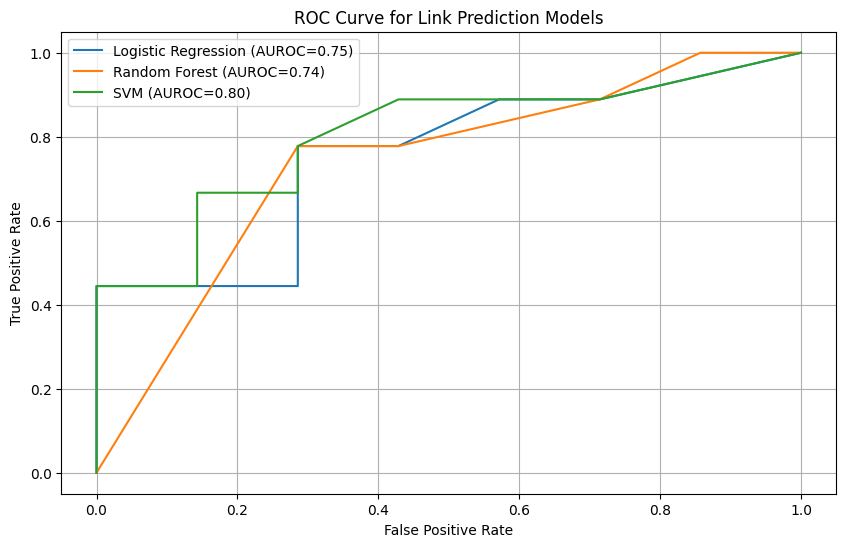

,Model,Accuracy,AUROC,Precision
0,Logistic Regression,0.75,0.753968,0.777778
1,Random Forest,0.75,0.738095,0.777778
2,SVM,0.75,0.801587,0.857143


In [ ]:
# Train and evaluate multiple models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results[model_name] = {
        "Accuracy": accuracy,
        "AUROC": auroc,
        "Precision": precision,
        "FPR": fpr,
        "TPR": tpr
    }

plt.figure(figsize=(10, 6))
for model_name, metrics in results.items():
    plt.plot(metrics["FPR"], metrics["TPR"], label=f"{model_name} (AUROC={metrics['AUROC']:.2f})")

plt.title("ROC Curve for Link Prediction Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    model_name: {
        "Accuracy": metrics["Accuracy"],
        "AUROC": metrics["AUROC"],
        "Precision": metrics["Precision"]
    }
    for model_name, metrics in results.items()
}).T

results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)
results_df